In [154]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from scipy.stats import norm

In [135]:
results = []
results_dir = './20231004145115_sim_mar/results/'
for filename in os.listdir(results_dir):
    with open(f'{results_dir}/{filename}', 'rb') as f:
        res = pickle.load(f).to_dict()
        res.update(res['result'])
        del res['result']
        results.append(pd.Series(res))

df = pd.DataFrame(results)
with open('./20231004145115_sim_mar/results_all.pickle', 'wb') as f:
    pickle.dump(df, f)

In [146]:
with open(f'./20231004145115_sim_mar/results_all.pickle', 'rb') as f:
    df = pickle.load(f)

df_wasserstein = df[df['sim_setup'] == 'wasserstein'].copy()
df_r = df[df['sim_setup'] == 'r'].copy()

_df = df_r

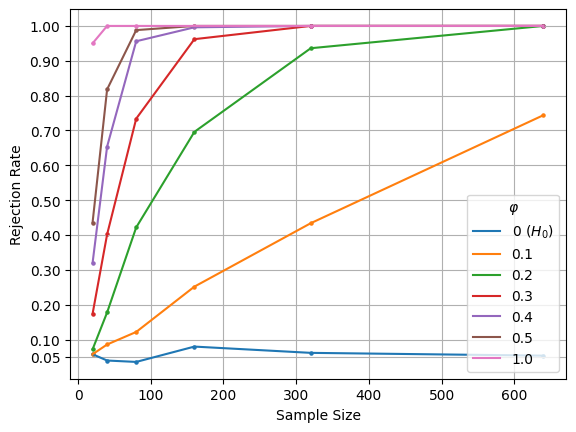

In [142]:
def compute_critical_val(df, quantiles_field, alpha):
    computed_alphas = np.linspace(0, 1, 50)
    def _comp(qs): return np.interp(alpha, computed_alphas, qs)
    return df[quantiles_field].apply(_comp)

alpha = 0.05
crit_Dt_lo = compute_critical_val(_df, 'quantiles_Dt', alpha/2)
crit_Dt_hi = compute_critical_val(_df, 'quantiles_Dt', 1 - alpha/2)

_df['rejected'] = (_df.Dt < crit_Dt_lo) | (_df.Dt > crit_Dt_hi)

results = _df.groupby(['sample_size', 'phi']).agg(rejection_rate=('rejected', 'mean')).reset_index()

for phi in results.phi.unique():
    sub_df = results[results['phi'] == phi]

    plt.scatter(sub_df['sample_size'], sub_df.rejection_rate, s=5)
    if phi == 0:
        plt.plot(sub_df['sample_size'], sub_df.rejection_rate, label=r'$0\ (H_0)$')
    else:
        plt.plot(sub_df['sample_size'], sub_df.rejection_rate, label=np.round(phi,1))
plt.xlabel('Sample Size')
plt.ylabel('Rejection Rate')
plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.yticks([0.05,0.1,0.2,0.3,0.4,0.5,0.6,.7,.8,.9,1]);
# plt.xticks(df['T'].unique())

plt.savefig('./rejection_rates_R_mult_noise.pdf')

Text(0, 0.5, '$d(\\mu, \\hat\\mu)^2$')

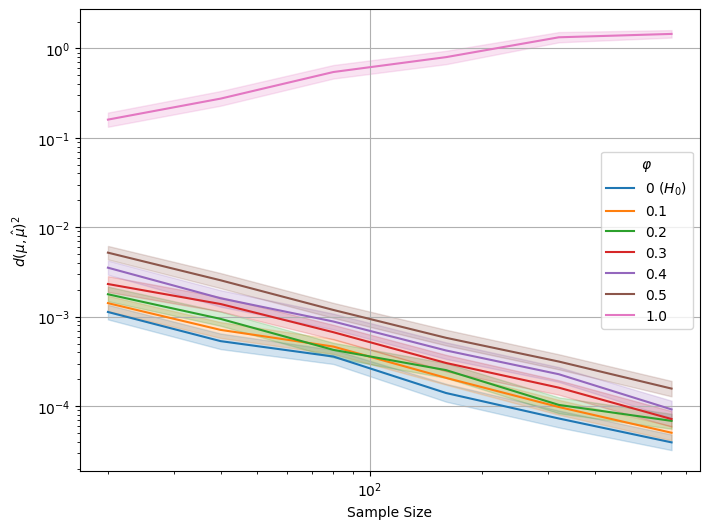

In [152]:
f, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")

for phi in np.sort(_df.phi.unique()):
    # if phi == 1:
    #     continue
    
    sub_df = _df[_df['phi'] == phi]

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='sample_size', y='err', label=label)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$d(\mu, \hat\mu)^2$')

Text(0, 0.5, '$\\left|\\hat\\varphi - \\varphi\\right|$')

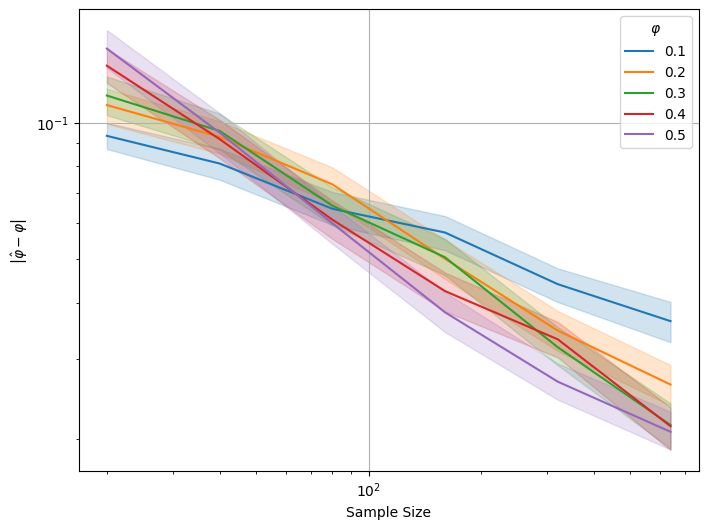

In [157]:
f, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")

for phi in np.sort(_df.phi.unique()):
    if phi == 0 or phi == 1:
        # ax.plot([], [], label=r'$0\ (H_0)$')
        continue
    sub_df = _df[_df['phi'] == phi].copy()
    sub_df['err_phi_hat'] = np.abs(sub_df['phi_hat'] - phi) + 1e-20

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='sample_size', y='err_phi_hat', label=label, ax=ax)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$\left|\hat\varphi - \varphi\right|$')

In [155]:
target_T = 100
true_size = np.linspace(0, 1, 40)

for phi in np.sort(_df['phi'].unique()):
    sub_df = _df[(_df['sample_size'] == target_T) & (_df['phi'] == phi)].copy()
    _M = sub_df.shape[0]

    rejection_rate = (np.repeat((np.abs(sub_df['Dt'] - sub_df['boot_mean_Dt']) / sub_df['boot_sig_Dt']).values,true_size.shape[0]).reshape((true_size.shape[0], _M)) > np.repeat(norm.ppf(1 - true_size/2), _M).reshape((true_size.shape[0], _M))).mean(axis=1)

    crit_Dt_lo = compute_critical_val(_df, 'quantiles_Dt', alpha/2)
    crit_Dt_hi = compute_critical_val(_df, 'quantiles_Dt', 1 - alpha/2)

    _df['rejected'] = (_df.Dt < crit_Dt_lo) | (_df.Dt > crit_Dt_hi)


    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    plt.scatter(true_size, rejection_rate, label=label, s=5)
plt.legend(title=r'$\varphi$')
plt.xlabel('Test level')
plt.ylabel('Empirical size')
plt.grid('on')


KeyError: 'boot_mean_Dt'